## jorn-20201023-pilotTMA


**Using Jørn Skavland's 20201023-pilotTMA data (id 1) provided 20201030**<br>

Arvid Lundervold, v20201031

------------

date:	Oct 30, 2020, 4:14 PM
subject:	SV: Hyperion og .mcd rådata - postprocessing / bildeanalyse / maskinlæring

Jørn Skavland <Jorn.Skavland@uib.no> 

Hei,

Sender deg data for en kjøring av flere vevsbiter på samme glass-slide Sender den via Filesender. 
Det vil si at du vil få en «hovedfil» 20201023_pilotTMA.mcd som kan åpnes i MCD Viewer I tillegg 
så følger alle tekstfilene som lagres i «sanntid» mens maskinen kjøres. Vet ikke om eller evt 
hvordan denne omgjøres ved generering av .mcd-filen. Programvaren til Maskinen kan lastes ned ved 
registrering (maskinnummer xxx)  CyTOF v7.0
Ser gjerne på prosjekt og hva dere tenker rundt analyse av disse dataene. Min GitHub er @jskavland

-------

`imctools` is a python package to handle IMC raw files (.mcd & .txt) and convert them to a vendor independent OME.TIFF format. Further it handles converting OME.TIFF to a variety of other TIFF formats. Can be used in a IMC segmentation pipeline to prepare the data for CellProfiller.

(cf. https://github.com/BodenmillerGroup/imctools)

The OME.TIFF will have a standardized, yet user controlled (say: modifiable, user generatable vs. vendor controlled, instrument specific) way to store raw data of multiplexed images alongside with acquisition specific metadata in order to make it independent of IMC as a technology. As a user of cyTOF-IMC only data this might be not so important (as long as Fluidigm never changes the .mcd file format), but in the view that maybe one day there will be other multiplexed image technology vendors it might be worth to build the data analysis in a way that starts with a user controlled format. Also if everybody (speak also Ilastik, CellProfiller, HistoCAT's, ImageJ) would respect his open standard, everything would get much more compatible and easier to interface between programs (e.g. dealing with IMC image data as an image5d stack).
Unfortunately - despite much talk - the OME.TIFF's are as widely supported (yet) as one would hope. There are some programs that support them e.g. OME.TIFF's generated from IMC can be loaded and viewed in OMERO (https://www.openmicroscopy.org/omero) and are also correctly recognized in FIJI (however the support once loading is till quite cumbersome).

- Vito http://www.imc-forum.org/viewtopic.php?f=4&t=7

### histoCAT Software for Computational Imaging Mass Cytometry Analysis
histoCAT software is an innovative computational IMC analysis toolbox that enables comprehensive analysis of cellular phenotypes and their interrelationships within the spatial context of the tissue microenvironment. Developed in the laboratory of Bernd Bodenmiller at the University of Zurich, histoCAT includes novel algorithms to identify the relationships and “social networks” between cells in healthy and disease states and across experimental cohorts. Under an agreement with the University of Zurich, Fluidigm obtained rights to globally distribute histoCAT along with the Hyperion Imaging System.

### histoCAT++

See also histoCAT++ -  now commercially distributed by Fluidigm for customers using Hyperion Imaging System for Imaging Mass Cytometry and the histoCAT++ software binaries can also be
downloaded [histoCAT++](http://www.bodenmillerlab.org/histoCAT_downloads/histoCAT++.zip) (macOS only) (New version 3.0 – 5 May 2020. With bug fixes, improved memory use, compensation functions enabled, fcs export, better label system for tiles, and adapted for High Sierra. Much smaller download. See also the manual at http://www.bodenmillerlab.org/histoCAT_manual/index.php/manual_plus

In [6]:
# To display plots directly in the notebook:
%matplotlib inline
import numpy as np
import pandas as pd
from imctools.io.mcd.mcdparser import McdParser
import matplotlib.pyplot as plt
import tifffile as tiff
import os
home = os.path.expanduser('~')  # To make path to local home directory

In [7]:
# 20201023_pilotTMA.mcd  - 2.85 GB
#fn_basedir = '%s/prj/Hyperion_IMC' % (home)
fn_basedir = '/mnt/sata12tb/prj/Hyperion_IMC'
fn_study = '20201023_pilotTMA'
fn_mcd = '%s/%s/%s.mcd' % (fn_basedir, fn_study, fn_study)

In [8]:
def get_mcd_data_metadate(fn, idno):
    """
    Takes MCD file name and returns data and metadata for id number idno
    """
    
    parser = McdParser(fn_mcd)
    # Get original metadata in XML format
    xml = parser.get_mcd_xml()
    
    # Get parsed session metadata (i.e. session -> slides -> acquisitions -> channels, panoramas data)
    session = parser.session
    
    # Get all acquisition IDs
    ids = parser.session.acquisition_ids
    n_ids = np.max(ids)
    
    # The common class to represent a single IMC acquisition is AcquisitionData class.
    # Get acquisition data for acquisition with id 1
    ac_data = parser.get_acquisition_data(idno)
    
    imc_data = ac_data.image_data
    n_chn = imc_data.shape[0]
    nx = imc_data.shape[1]
    ny = imc_data.shape[2]
    
    # Read channel metadata into dictionaries
    dinames = dict(zip(ac_data.channel_names, range(len(ac_data.channel_names))))
    dilabs = dict(zip(ac_data.channel_labels, range(len(ac_data.channel_labels))))
    dimasses = dict(zip(ac_data.channel_masses, range(len(ac_data.channel_masses))))
    
    # Make a dataframe from channel metadata
    df1 = pd.DataFrame(list(dinames.items()), columns=['name', 'chn'])
    df2 = pd.DataFrame(list(dilabs.items()), columns=['label', 'chn'])
    df3 = pd.DataFrame(list(dilabs.items()), columns=['mass', 'chn'])
    df4 = pd.merge(df1, df2, on='chn')
    df = pd.merge(df4, df3, on='chn')
    df = df.reindex(columns=['chn', 'name', 'label', 'mass'])
    df['chn'] = df['chn']+1
    
    # as the mcd object is using lazy loading memory maps, it needs to be closed
    # or used with a context manager
    parser.close()
    
    return df, n_ids, n_chn, nx, ny, imc_data


In [9]:
idno = 1
my_df, my_n_ids, my_n_chn, my_nx, my_ny, my_imc_data  = get_mcd_data_metadate(fn_mcd, idno)

In [10]:
my_df

chn    name              label               mass
0     1  ArAr80             80ArAr             80ArAr
1     2     Y89                89Y                89Y
2     3    Ru96               96Ru               96Ru
3     4    Ru98               98Ru               98Ru
4     5    Ru99               99Ru               99Ru
5     6   Ru100              100Ru              100Ru
6     7   Ru101              101Ru              101Ru
7     8   Ru102              102Ru              102Ru
8     9   Ru104              104Ru              104Ru
9    10    I127               127I               127I
10   11   Xe131              131Xe              131Xe
11   12   Ba138              138Ba              138Ba
12   13   Pr141         141Pr_aSMA         141Pr_aSMA
13   14   Nd142   142Nd_Keratin5_6   142Nd_Keratin5_6
14   15   Nd143          143Nd_p53          143Nd_p53
15   16   Nd144          144Nd_VWF          144Nd_VWF
16   17   Nd145           145Nd_PR           145Nd_PR
17   18   Nd146        146Nd_FoxA1        146Nd_FoxA1
18   19   Sm147        147Sm_CD163        147Sm_CD163
19   20   Nd148   148Nd_panKeratin   148Nd_panKeratin
20   21   Sm149     149Sm_Stathmin     149Sm_Stathmin
21   22   Nd150         150Nd_PDL1         150Nd_PDL1
22   23   Eu151         151Eu_CD31         151Eu_CD31
23   24   Sm152       152Sm_Nestin       152Sm_Nestin
24   25   Eu153         153Eu_CD44         153Eu_CD44
25   26   Sm154          154Sm_INA          154Sm_INA
26   27   Gd155        155Gd_FoxP3        155Gd_FoxP3
27   28   Gd156          156Gd_CD4          156Gd_CD4
28   29   Gd158         158Gd_NCam         158Gd_NCam
29   30   Tb159         159Tb_CD68         159Tb_CD68
30   31   Gd160       160Gd_PDGFRa       160Gd_PDGFRa
31   32   Dy161         161Dy_CD20         161Dy_CD20
32   33   Dy162          162Dy_CD8          162Dy_CD8
33   34   Dy163           163Dy_ER           163Dy_ER
34   35   Dy164    164Dy_Keratin14    164Dy_Keratin14
35   36   Ho165          165Ho_PD1          165Ho_PD1
36   37   Er166         166Er_Her2         166Er_Her2
37   38   Er167        167Er_GATA3        167Er_GATA3
38   39   Er168         168Er_Ki67         168Er_Ki67
39   40   Tm169         169Tm_PDPN         169Tm_PDPN
40   41   Er170          170Er_CD3          170Er_CD3
41   42   Yb171       171Yb_PDGFRb       171Yb_PDGFRb
42   43   Yb172        172Yb_CTLA4        172Yb_CTLA4
43   44   Yb173          173Yb_DCX          173Yb_DCX
44   45   Yb174  174Yb_Keratin8_18  174Yb_Keratin8_18
45   46   Lu175     175Lu_Neurofil     175Lu_Neurofil
46   47   Yb176           176Yb_H3           176Yb_H3
47   48   Ir191              191Ir              191Ir
48   49   Ir193              193Ir              193Ir
49   50   Pb208              208Pb              208Pb

In [11]:
print('Number of ids in %s:' % (fn_study), my_n_ids)

Number of ids in 20201023_pilotTMA: 11


In [12]:
my_shape = [my_n_chn, my_nx, my_ny]
print('Number of chnannels, xsize, ysize in %s (id %d):' % (fn_study, idno), my_shape)

Number of chnannels, xsize, ysize in 20201023_pilotTMA (id 1): [50, 1105, 1097]


### Print figures to PDF-file for use in LaTeX

In [20]:
# For direct inclusion of figures and tables in the Overleaf on Linux / MacOS and NOT Windows ('nt')
# i.e. LaTeX document (Overleaf is synced with Dropbox on MacOS/Linux)
Dropbox_base = '/mnt/sata12tb'
if os.name == 'nt':
    fn_fig_base = '%s/tmp' % home
    fn_tab_base = '%s/tmp' % home
else:    
    fn_fig_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020/Figs' % (Dropbox_base)
    fn_tab_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020' % (Dropbox_base)

In [21]:
df = my_df
n_chn = my_n_chn
im = my_imc_data

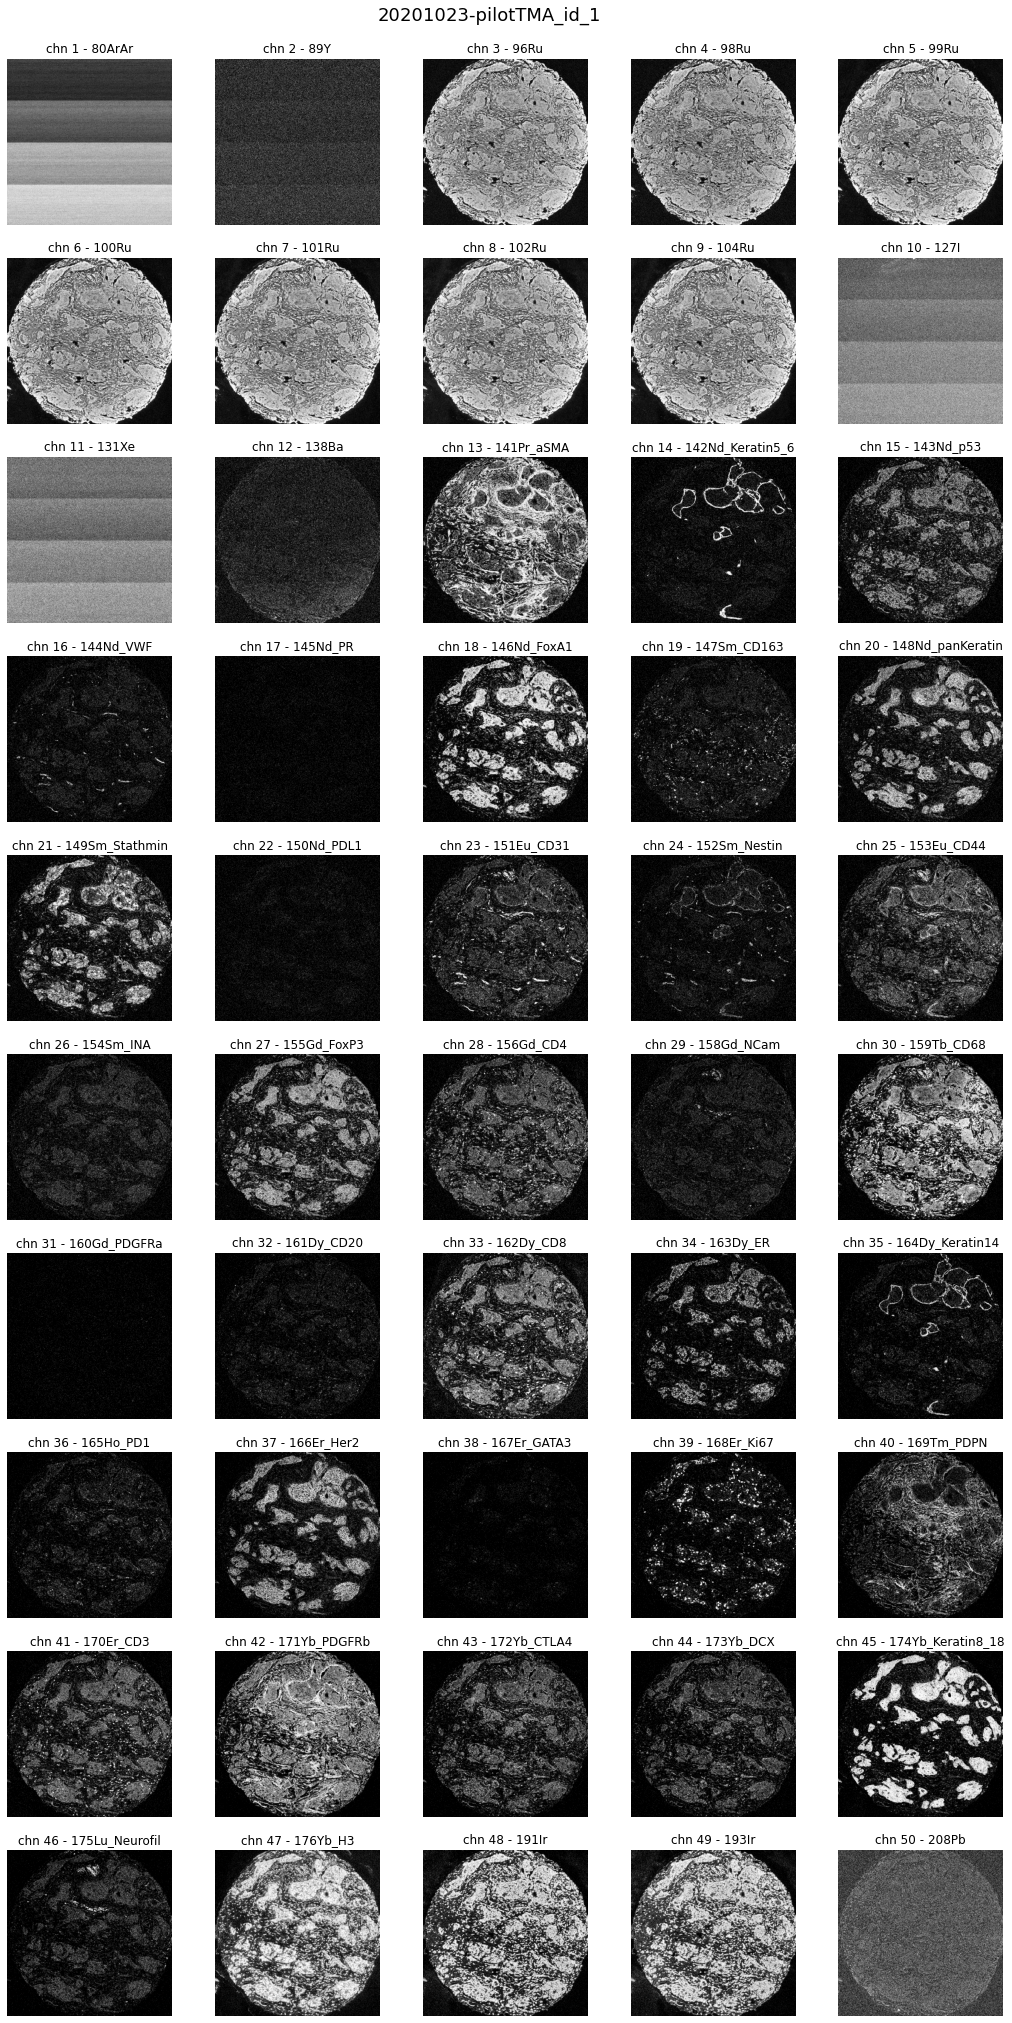

In [25]:
fig_fn = '%s/BMED320_experiments_jorn-20201023-pilotTMA_id_%d_channel_eq_mosaic_gray.pdf' % (fn_fig_base, idno)

fig, axes = plt.subplots(10, 5, figsize=(18, 36), sharex=False, sharey=False)
#fig.subplots_adjust(top=0.8)
ax = axes.ravel()
for i, item in enumerate(range(n_chn)):
    chn = np.squeeze(im[i,:,:])
    chn_eq = np.sort(chn.ravel()).searchsorted(chn)  # a kind of histogram equalization
    ax[i].imshow(chn_eq, cmap='gray' )   # cmap='jet', 'gray'
    ax[i].set_title('chn %d - %s' % (df.chn.iloc[i], df.label.iloc[i]))
    ax[i].axis('off')

plt.suptitle('20201023-pilotTMA_id_%d' % (idno), y=0.90, size=18)
plt.savefig(fig_fn, bbox_inches='tight')

plt.show()

In [26]:
def get_ac_data(fn, idno):
    """
    Takes MCD file name and returns data and metadata for id number idno
    """
    
    parser = McdParser(fn_mcd)
    # Get original metadata in XML format
    xml = parser.get_mcd_xml()
    
    # Get parsed session metadata (i.e. session -> slides -> acquisitions -> channels, panoramas data)
    session = parser.session
    
    # Get all acquisition IDs
    ids = parser.session.acquisition_ids
    n_ids = np.max(ids)
    
    # The common class to represent a single IMC acquisition is AcquisitionData class.
    # Get acquisition data for acquisition with id 1
    ac_data = parser.get_acquisition_data(idno)
    
    parser.close()
    
    return ac_data

In [27]:
ac_data = get_ac_data(fn_mcd, idno)

In [28]:
# imc acquisitions can yield the image data by name (tag), label or index
chn1 = ac_data.get_image_by_name('Nd142')   # chn 13+1
chn2 = ac_data.get_image_by_label('148Nd_panKeratin')  # chn 19+1
chn3 = ac_data.get_image_by_index(34)    # 164Dy_Keratin14  chn 34+1
chn4 = ac_data.get_image_by_label('191Ir')    # chn 47+1
print(chn1.shape)
print(chn1.min(), chn1.max())

(1105, 1097)
0.0 60.438007


In [29]:
def hist_eq(chn):
    return np.sort(chn.ravel()).searchsorted(chn)

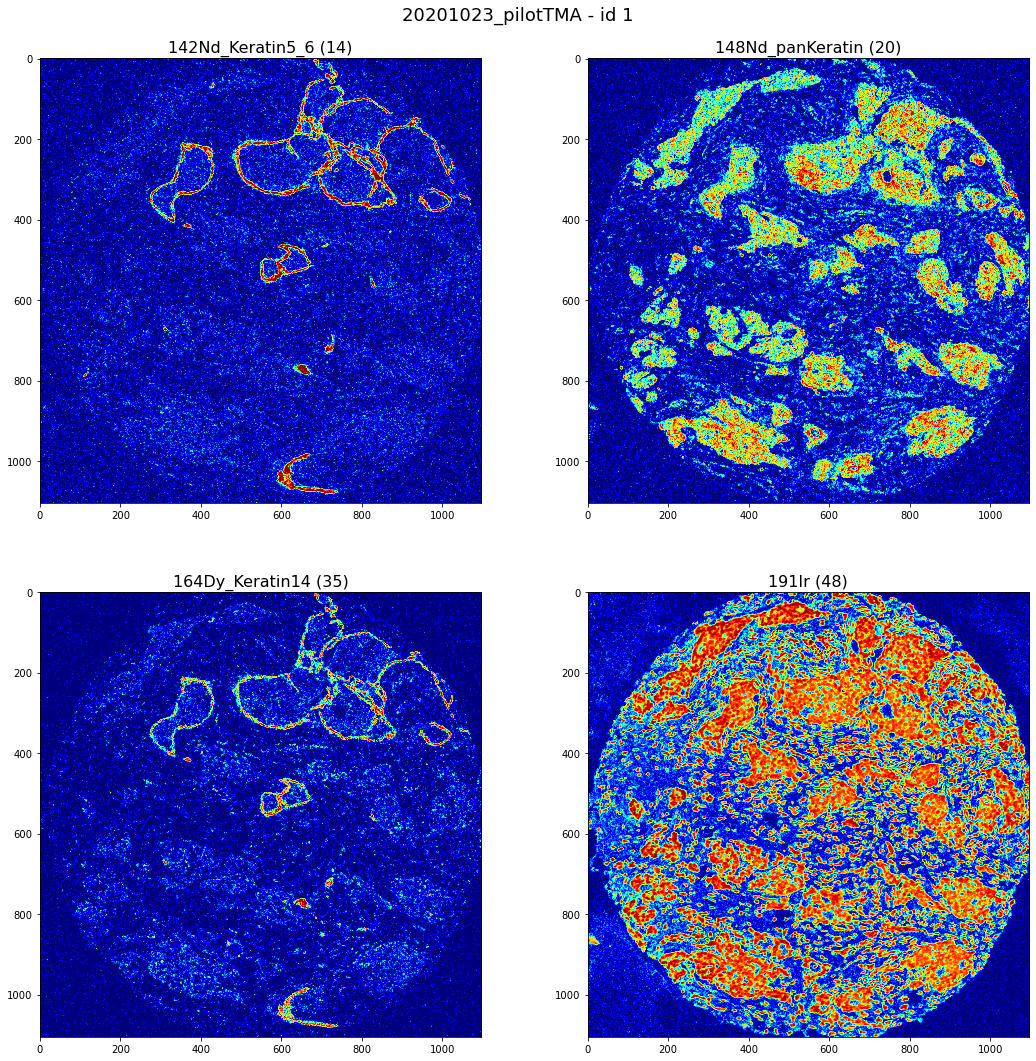

In [30]:
fig_fn = '%s/BMED320_experiments_jorn-20201023-pilotTMA_id_%d_4_channels_eq_jet.pdf' % (fn_fig_base, idno)

my_cmap = 'jet'   # 'gray'
fig, axes = plt.subplots(2, 2, figsize=(18, 18), sharex=False, sharey=False)
ax = axes.ravel()
ax[0].imshow(hist_eq(chn1), cmap=my_cmap)
ax[0].set_title("142Nd_Keratin5_6 (14)", fontsize=16)
ax[1].imshow(hist_eq(chn2), cmap=my_cmap)
ax[1].set_title("148Nd_panKeratin (20)", fontsize=16)
ax[2].imshow(hist_eq(chn3), cmap=my_cmap)
ax[2].set_title("164Dy_Keratin14 (35)", fontsize=16)
ax[3].imshow(hist_eq(chn4), cmap=my_cmap)
ax[3].set_title("191Ir (48)", fontsize=16)
plt.suptitle('20201023_pilotTMA - id 1', y=0.92, fontsize=18)
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

### Save multichannel IMC file (for given id) as TIFF

In [31]:
# or can be used to save OME-TIFF files
fn_out ='./data/Jorn/20201023_pilotTMA_id01_4chn.ome.tiff'
#ac_data.save_ome_tiff(fn_out, names=['142Nd-Keratin5-6', '148Nd-panKeratin', '164Dy-Keratin14', '191Ir'])

In [32]:
# save multiple standard TIFF files in a folder
#ac_data.save_tiffs("./data/Sina/2020-Feb-05_BC24", compression=0, bigtiff=False)

In [33]:
#tiff.imsave('%s/Desktop/2020-Feb-05_BC24s2.tiff' % (home), np.float32(ac_data.image_data))

#tiff.imsave('%s/Desktop/20201023_pilotTMA_id_%d.tiff' % (home, idno), np.float32(ac_data.image_data))
#df.to_csv('./data/Jorn/20201023_pilotTMA_id_%d.csv' % (idno), index=False)